In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from pathlib import Path

in_csv = "atom_counts.csv"
out_csv = "atom_counts_dedup.csv"

df = pd.read_csv(in_csv)

In [2]:
# Count duplicates, clean up data
n_before = len(df)
n_unique_before = df["pdb_code"].nunique()

# Keep first of each duplicate
df_dedup = df.drop_duplicates(subset=["pdb_code"], keep="first").copy()

n_after = len(df_dedup)

print(f"Rows before: {n_before}")
print(f"Rows after : {n_after}")

# Only save if something changed
if n_after < n_before:
    df_dedup.to_csv(out_csv, index=False)
    print(f"Duplicates found, saved deduplicated file to '{out_csv}'")
else:
    print("No duplicates found, no new file saved")

Rows before: 18415
Rows after : 18415
No duplicates found, no new file saved


In [3]:
RAW_CSV = Path("atom_counts.csv")
CLEAN_CSV = Path("atom_counts_dedup.csv")

if CLEAN_CSV.exists():
    print(f"Using cleaned file: {CLEAN_CSV}")
    df = pd.read_csv(CLEAN_CSV)
else:
    print(f"Cleaned file not found, using raw file: {RAW_CSV}")
    df = pd.read_csv(RAW_CSV)

print(f"Loaded {len(df)} rows")
df.head()


Cleaned file not found, using raw file: atom_counts.csv
Loaded 18415 rows


,pdb_code,phase,gro,protein_atoms,protein_heavy_atoms,n_ca,n_residues,n_chains,total_atoms
0,168l,1,/work001/misc/bekker/kakC/dynamicsdb/raw/1/168...,2601,1289,164,164,1,22429
1,1a2a,1,/work001/misc/bekker/kakC/dynamicsdb/raw/1/1a2...,1838,961,122,122,1,16222
2,1aow,1,/work001/misc/bekker/kakC/dynamicsdb/raw/1/1ao...,4890,2448,309,309,1,39183
3,1atu,1,/work001/misc/bekker/kakC/dynamicsdb/raw/1/1at...,5953,2963,374,374,1,43698
4,1bol,1,/work001/misc/bekker/kakC/dynamicsdb/raw/1/1bo...,3217,1688,222,222,1,25813


In [4]:
#Check to make sure there are no 0 values
df = df[
    (df["protein_heavy_atoms"] > 0) &
    (df["n_residues"] > 0) &
    (df["n_ca"] > 0)
].copy()

print(f"Remaining valid proteins: {len(df)}")


Remaining valid proteins: 18415


In [5]:
summary = df[[
    "protein_heavy_atoms",
    "n_ca",
    "n_residues",
    "n_chains",
]].describe()

#pd.options.display.float_format = "{: .0f}".format
summary.style.format("{:.0f}")

,protein_heavy_atoms,n_ca,n_residues,n_chains
count,18415,18415,18415,18415
mean,2203,280,281,1
std,2321,299,300,0
min,28,4,4,1
25%,1018,127,128,1
50%,1520,198,198,1
75%,2562,324,325,1
max,29766,4356,4356,1


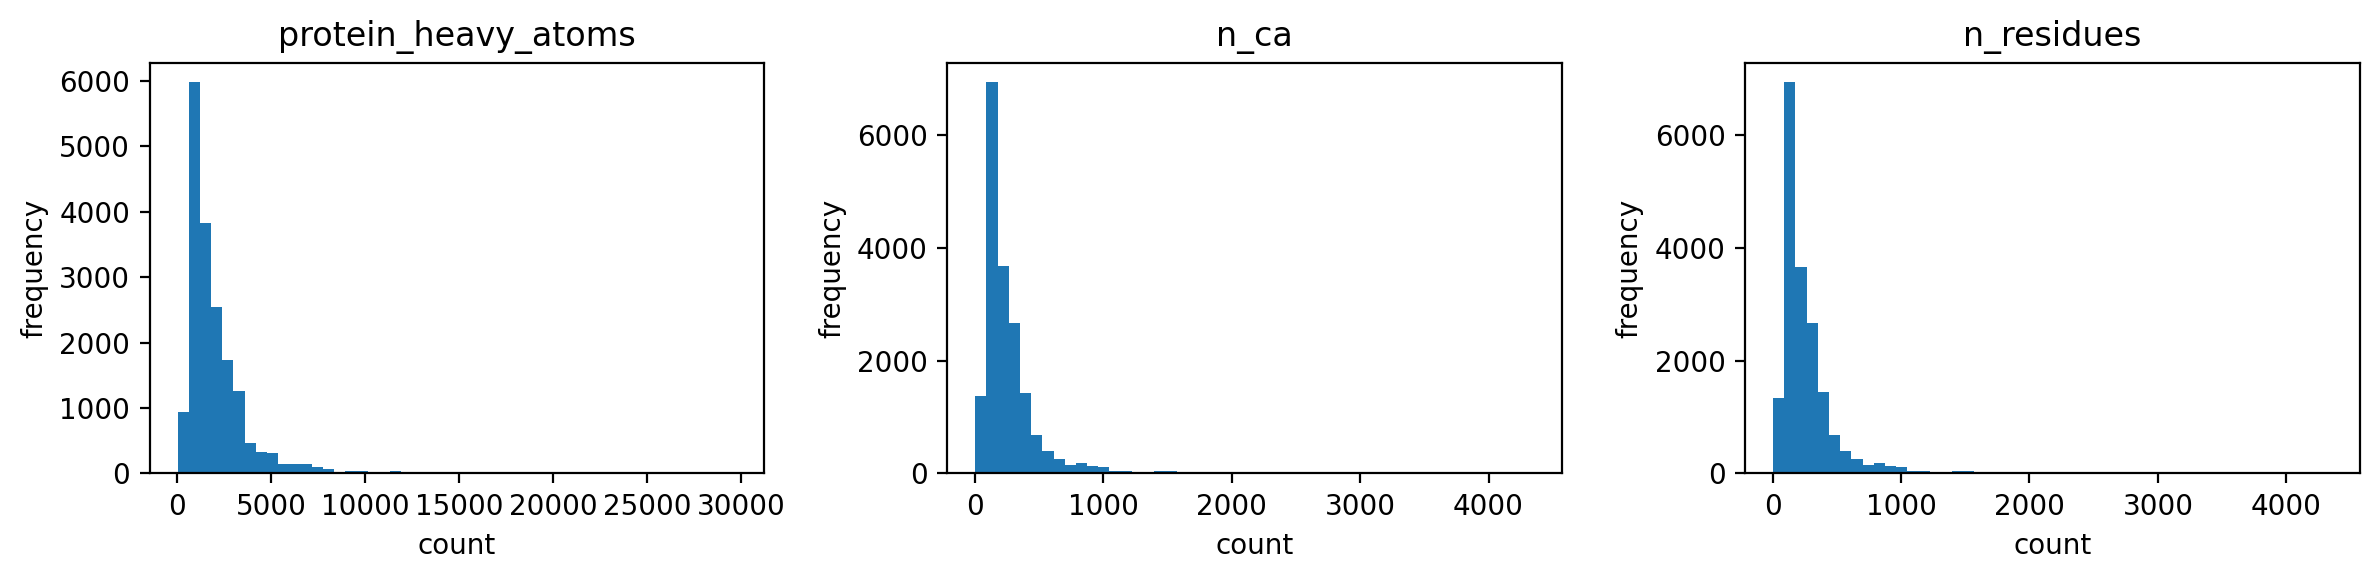

In [6]:
plt.rcParams["figure.dpi"] = 200
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, col in zip(
    axes,
    ["protein_heavy_atoms", "n_ca", "n_residues"]
):
    ax.hist(df[col], bins=50)
    ax.set_title(col)
    ax.set_xlabel("count")
    ax.set_ylabel("frequency")

plt.tight_layout()
plt.show()

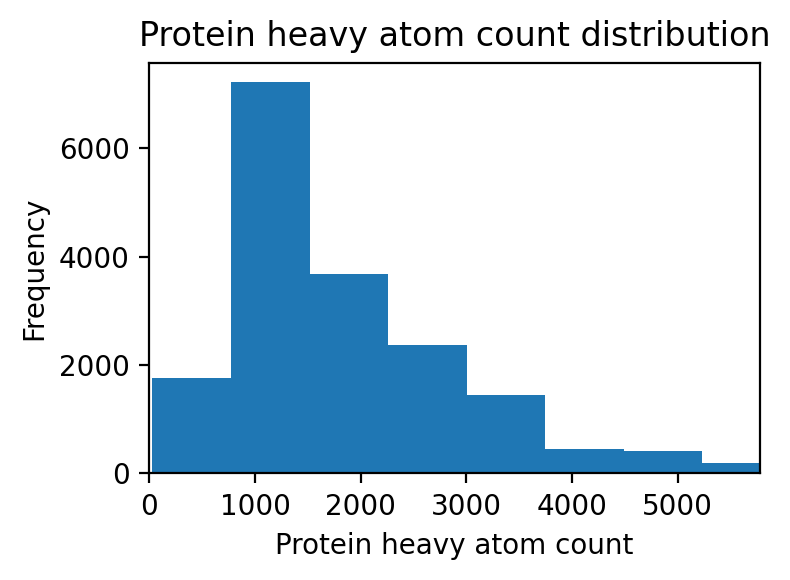

In [7]:
plt.rcParams["figure.dpi"] = 200

data = df["protein_heavy_atoms"].dropna().values

fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(data, bins=40)   # <-- YOU control this
ax.set_xlabel("Protein heavy atom count")
ax.set_ylabel("Frequency")
ax.set_title("Protein heavy atom count distribution")
ax.set_xlim(0, np.percentile(data, 95))

plt.tight_layout()
plt.show()

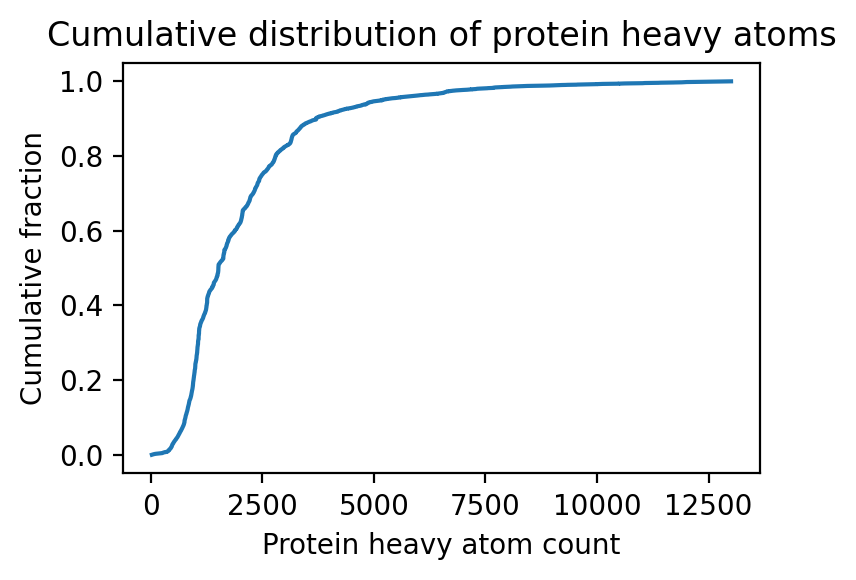

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

data = np.sort(df["protein_heavy_atoms"].dropna().values)

# Optional clipping
xmax = np.quantile(data, 0.99)
data_plot = data[data <= xmax]

y = np.arange(1, len(data_plot) + 1) / len(data_plot)

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(data_plot, y)
ax.set_xlabel("Protein heavy atom count")
ax.set_ylabel("Cumulative fraction")
ax.set_title("Cumulative distribution of protein heavy atoms")

plt.tight_layout()
plt.show()


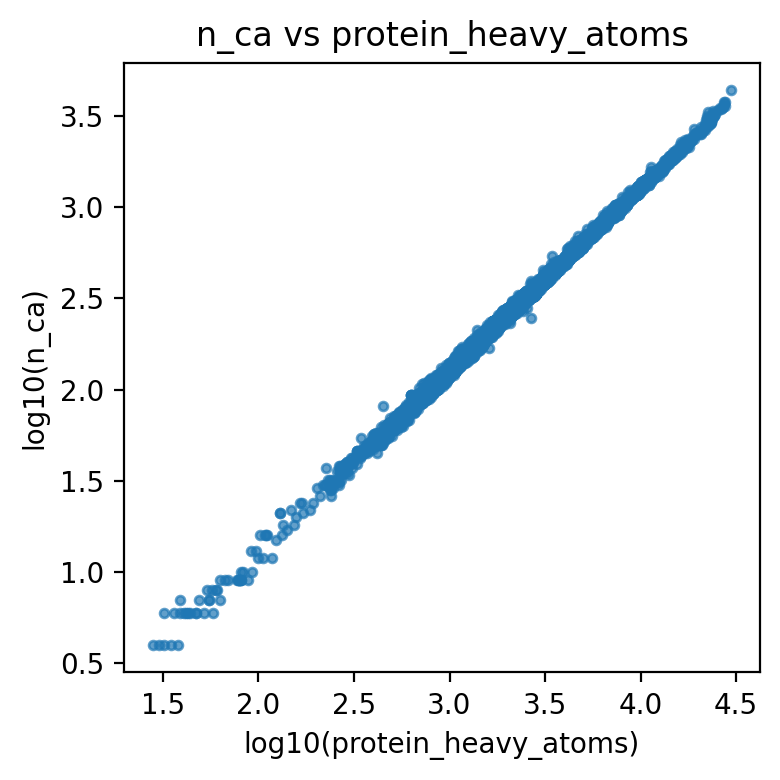

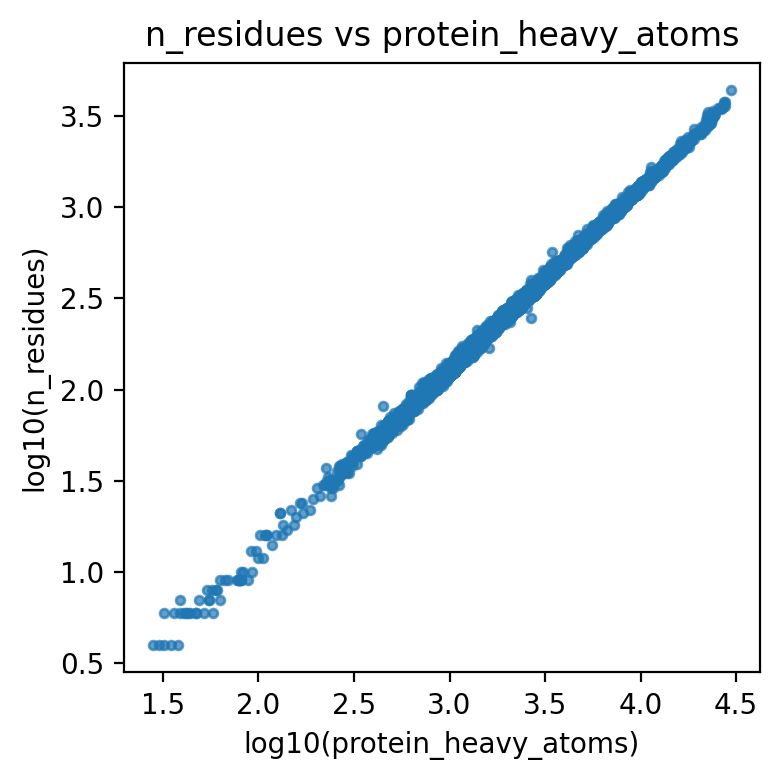

In [9]:
pairs = [
    ("protein_heavy_atoms", "n_ca"),
    ("protein_heavy_atoms", "n_residues"),
]

for xcol, ycol in pairs:
    plt.figure(figsize=(4, 4))
    plt.scatter(
        np.log10(df[xcol]),
        np.log10(df[ycol]),
        s=10,
        alpha=0.7,
    )
    plt.xlabel(f"log10({xcol})")
    plt.ylabel(f"log10({ycol})")
    plt.title(f"{ycol} vs {xcol}")
    plt.tight_layout()
    plt.show()

In [10]:
def fit_scaling(x, y):
    res = linregress(np.log(x), np.log(y))
    return res.slope, res.rvalue**2

for xcol, ycol in pairs:
    alpha, r2 = fit_scaling(df[xcol], df[ycol])
    print(f"{ycol} ~ {xcol}^α : α = {alpha:.3f}, R² = {r2:.3f}")

n_ca ~ protein_heavy_atoms^α : α = 1.002, R² = 0.997
n_residues ~ protein_heavy_atoms^α : α = 0.999, R² = 0.997


In [11]:
col = "protein_heavy_atoms"

# Determine data range
vmin = df[col].min()
vmax = df[col].max()

# Create bins of width 200
bin_edges = np.arange(
    (vmin // 200) * 200,   # round down
    ((vmax // 200) + 1) * 200 + 1,
    200
)

df_binned = df.copy()
df_binned["bin_edges"] = pd.cut(
    df_binned[col],
    bins=bin_edges,
    right=False,          # [a, b)
    include_lowest=True,
)

# Optional: numeric bin ID (very handy later)
df_binned["size_bin_id"] = df_binned["bin_edges"].cat.codes

df_binned[["pdb_code", col, "bin_edges", "size_bin_id"]].head()

,pdb_code,protein_heavy_atoms,bin_edges,size_bin_id
0,168l,1289,"[1200, 1400)",6
1,1a2a,961,"[800, 1000)",4
2,1aow,2448,"[2400, 2600)",12
3,1atu,2963,"[2800, 3000)",14
4,1bol,1688,"[1600, 1800)",8


In [12]:
N_PER_BIN = 999

df_sel = (
    df_binned
    .dropna(subset=["bin_edges"])          # only valid bins
    .groupby("bin_edges", group_keys=False)
    .apply(lambda g: g.sample(
        n=min(len(g), N_PER_BIN),          # avoid errors for small bins
        random_state=42                    # reproducible
    ))
)

df_sel[["pdb_code", "protein_heavy_atoms", "bin_edges"]].head()
df_sel.to_csv("atom_count_binned_sample.csv", index=False)

/tmp/ipykernel_464633/3019514059.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin_edges", group_keys=False)
/tmp/ipykernel_464633/3019514059.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


In [13]:
df["protein_heavy_atoms"].agg(["min", "max"])
min_row = df.loc[df["protein_heavy_atoms"].idxmin()]
max_row = df.loc[df["protein_heavy_atoms"].idxmax()]

print(f"Min: {min_row.pdb_code} ({min_row.protein_heavy_atoms})")
print(f"Max: {max_row.pdb_code} ({max_row.protein_heavy_atoms})")


Min: 5zck (28)
Max: 6w8x (29766)


In [15]:
bin_col = "bin_edges"   # your pd.cut output column
label_col = "bin_label"

# Make string labels that match your chosen_bins formatting
df_binned[label_col] = df_binned[bin_col].astype(str)

chosen_bins = [
    "[800, 1000)",
    "[1200, 1400)",
    "[1600, 1800)",
    "[2000, 2200)",
    "[2200, 2400)",
    "[2600, 2800)",
    "[3000, 3200)",
    "[3400, 3600)",
    "[3800, 4000)",
    "[4200, 4400)",
]

N_PER_BIN = 10

df_sel = (
    df_binned
    .loc[df_binned[label_col].isin(chosen_bins)]
    .groupby(label_col, group_keys=False)
    .apply(lambda g: g.sample(n=min(len(g), N_PER_BIN), random_state=42))
)

print("Selected rows:", len(df_sel))
print(df_sel[label_col].value_counts().sort_index())

out_csv = "pdb_selection.csv"
df_sel.to_csv(out_csv, index=False)
print(f"Wrote {len(df_sel)} rows to {out_csv}")


Selected rows: 100
bin_label
[1200, 1400)    10
[1600, 1800)    10
[2000, 2200)    10
[2200, 2400)    10
[2600, 2800)    10
[3000, 3200)    10
[3400, 3600)    10
[3800, 4000)    10
[4200, 4400)    10
[800, 1000)     10
Name: count, dtype: int64
Wrote 100 rows to pdb_selection.csv


/tmp/ipykernel_464633/3775045992.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), N_PER_BIN), random_state=42))


In [ ]:
bin_col = "bin_edges"  # change to "size_bin" if that’s your column

df_binned[bin_col].value_counts().loc[chosen_bins].fillna(0)


KeyError: "None of [Index(['[800, 1000)', '[1200, 1400)', '[1600, 1800)', '[2000, 2200)',\n       '[2200, 2400)', '[2600, 2800)', '[3000, 3200)', '[3400, 3600)',\n       '[3800, 4000)', '[4200, 4400)'],\n      dtype='object', name='bin_edges')] are in the [index]"